<a href="https://colab.research.google.com/github/AmandiW/ci-coursework/blob/main/moga_optimized_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install deap

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve,
    auc,
    precision_recall_curve
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Suppress warnings
warnings.filterwarnings('ignore')

# Genetic Algorithm Libraries
from deap import base, creator, tools, algorithms


In [3]:
# Random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [10]:
class StrokeModelOptimizer:
    def __init__(self, filepath):
        """
        Initialize data, Genetic Algorithm (GA) settings, and constraints.
        """

        # Load and preprocess data
        self.X_train, self.X_test, self.y_train, self.y_test, self.scaler = self.load_and_preprocess_data(filepath)

        # Enhanced GA Configuration
        self.POPULATION_SIZE = 20
        self.MAX_GENERATIONS = 10
        self.CROSSOVER_PROB = 0.6
        self.MUTATION_PROB = 0.9

        # Gene configuration: ranges for hyperparameters
        self.GENE_CONFIGS = {
            'neurons_layer1': (16, 512),
            'neurons_layer2': (32, 512),
            'dropout_rate1': (0.1, 0.6),
            'dropout_rate2': (0.1, 0.4),
            'learning_rate': (0.0001, 0.01),
            'l2_reg': (1e-4, 1)
        }
        self.TRAINING_EPOCHS = 20

        # Tracking variables
        self.generation_best_loss = []
        self.generation_diversity = []
        self.generation_individuals = []
        self.generation_best_accuracy = []

        # Global Optima
        # Added a variable to track the absolute best individual across all generations
        self.absolute_best_individual = None
        self.absolute_best_fitness = (float('-inf'), float('inf'))  # Initialize with the worst possible fitness

        # Initialize Hall of Fame - CURRENTLY COMMENTED OUT TO REDUCE OUTPUT (already printing the best individuals in the output)
        # self.hof = tools.HallOfFame(maxsize=10)  # Keep top 10 individuals

        self.setup_deap_framework()

    def load_and_preprocess_data(self, filepath):
        """Load dataset and preprocess."""
        df = pd.read_csv(filepath)
        X = df.drop('stroke', axis=1)
        y = df['stroke']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test, scaler

    def calculate_weighted_sum(self, fitness_values):
        """Calculate weighted sum based on multi-objective weights"""
        return fitness_values[0] * 1.0 + fitness_values[1] * -1.0

    def weighted_tournament_selection(self, individuals, k, tournsize=5):
        """Tournament selection using weighted sum of objectives"""
        selected = []
        for _ in range(k):
            tournament = random.sample(individuals, tournsize)
            # Use weighted sum for comparison
            winner = max(tournament,
                         key=lambda ind: self.calculate_weighted_sum(ind.fitness.values))
            selected.append(winner)
        return selected

    def setup_deap_framework(self):
        """Setup DEAP for GA optimization with proper multi-objective handling."""
        creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))  # Maximize accuracy, Minimize loss
        creator.create("Individual", list, fitness=creator.FitnessMulti)

        self.toolbox = base.Toolbox()

        # Gene initialization, generate a material attribute using a uniform distribution between defined values (constraints)
        for gene, (low, high) in self.GENE_CONFIGS.items():
            self.toolbox.register(f"attr_{gene}", random.uniform, low, high)

        self.toolbox.register("individual", tools.initCycle, creator.Individual,
                              (self.toolbox.attr_neurons_layer1,
                               self.toolbox.attr_neurons_layer2,
                               self.toolbox.attr_dropout_rate1,
                               self.toolbox.attr_dropout_rate2,
                               self.toolbox.attr_learning_rate,
                               self.toolbox.attr_l2_reg), n=1)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("mate", tools.cxBlend, alpha=0.5)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.3)
        self.toolbox.register("select", self.weighted_tournament_selection)
        self.toolbox.register("evaluate", self.evaluate_individual)

    def build_ann(self, individual):
        """Build an ANN model based on individual hyperparameters."""
        neurons1, neurons2, drop1, drop2, lr, l2_reg = individual
        model = Sequential([
            Dense(int(neurons1), activation='relu', input_shape=(self.X_train.shape[1],),
                  kernel_regularizer=l2(l2_reg)),
            Dropout(drop1),
            Dense(int(neurons2), activation='relu', kernel_regularizer=l2(l2_reg)),
            Dropout(drop2),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def evaluate_individual(self, individual):
        """Evaluate the performance of an ANN defined by individual genes."""
        try:
            model = self.build_ann(individual)  # Build model using individual's genes

            early_stopping = EarlyStopping(monitor='val_loss', patience=3,
                                           restore_best_weights=True)  # Early stopping to prevent overfitting

            # Train the model
            model.fit(self.X_train, self.y_train,
                      epochs=self.TRAINING_EPOCHS,
                      batch_size=64,
                      validation_split=0.2,
                      verbose=0,
                      callbacks=[early_stopping])

            # Evaluate on test data
            loss, acc = model.evaluate(self.X_test, self.y_test, verbose=0)

            # Clear model from memory
            tf.keras.backend.clear_session()
            del model

            # Fitness: Maximize accuracy Minimize loss
            return acc, loss
        except Exception as e:
            # print(f"Evaluation error: {e}")
            return 0, 1e6  # Penalize invalid individuals

    def is_individual_better(self, new_fitness, current_best_fitness):
        """Compare individuals using weighted sum approach"""
        new_weighted = self.calculate_weighted_sum(new_fitness)
        current_weighted = self.calculate_weighted_sum(current_best_fitness)
        return new_weighted > current_weighted

    def calculate_population_diversity(self, population):
        """Calculate population diversity based on gene variations"""
        if not population:
            return 0
        gene_diversity = []
        for gene_index in range(len(population[0])):
            gene_values = [ind[gene_index] for ind in population]
            gene_diversity.append(np.std(gene_values))
        return np.mean(gene_diversity)

    def run_optimization(self):
        # Reset tracking variables
        self.generation_best_loss = []
        self.generation_diversity = []
        self.generation_individuals = []
        self.generation_best_accuracy = []

        # Create initial population
        pop = self.toolbox.population(n=self.POPULATION_SIZE)

        # Evaluate initial population
        fitnesses = list(map(self.toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

            # Check if this is the absolute best individual so far
            if self.is_individual_better(fit, self.absolute_best_fitness):
                self.absolute_best_individual = list(ind)
                self.absolute_best_fitness = fit

        # Update HoF with initial population - CURRENTLY COMMENTED OUT TO REDUCE OUTPUT (already printing the best individuals in the output)
        # self.hof.update(pop)

        # Generational loop with enhanced tracking and diversity preservation
        for gen in range(self.MAX_GENERATIONS):
            # Calculate and track population diversity
            current_diversity = self.calculate_population_diversity(pop)
            self.generation_diversity.append(current_diversity)

            # Select next generation individuals using weighted selection
            offspring = self.toolbox.select(pop, len(pop) - self
                                            .POPULATION_SIZE // 10)  # Reduce size of offspring by 10%
            # Implement Elitism to make sure best individuals are taken forward
            elite = tools.selBest(pop, self.POPULATION_SIZE // 10)  # Select 10% of the population as elite
            offspring.extend(elite)  # Add elite individuals to the offspring

            offspring = list(map(self.toolbox.clone, offspring))

            # Apply crossover and mutation
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.CROSSOVER_PROB:
                    self.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < self.MUTATION_PROB:
                    self.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate individuals with invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

                # Check if this is the absolute best individual so far
                if self.is_individual_better(fit, self.absolute_best_fitness):
                    self.absolute_best_individual = list(ind)
                    self.absolute_best_fitness = fit

            # # Update Hall of Fame - CURRENTLY COMMENTED OUT TO REDUCE OUTPUT (already printing the best individuals in the output)
            # self.hof.update(offspring)

            # Replace population
            pop[:] = offspring

            # Track generation statistics
            best_ind = max(pop, key=lambda x: self.calculate_weighted_sum(x.fitness.values))
            self.generation_best_loss.append(best_ind.fitness.values[1])
            self.generation_best_accuracy.append(best_ind.fitness.values[0])

            # Store information about each individual in this generation
            self.generation_individuals.append([])
            for ind in offspring:
                ind_info = {"individual": ind, "fitness": ind.fitness.values}
                self.generation_individuals[-1].append(ind_info)

            # Print generation details
            print(f"\nGeneration {gen + 1}:")
            print(f"Diversity: {current_diversity}")
            print("\nAll Individuals in this Generation:")

            for i, ind_info in enumerate(self.generation_individuals[-1], 1):
                print(f"Individual {i}: {ind_info['individual']}")
                print(f"Fitness (Accuracy, Loss): {ind_info['fitness']}\n")

            print(f"Best Individual: {best_ind}")
            print(f"Best Accuracy: {best_ind.fitness.values[0]}")
            print(f"Best Loss: {best_ind.fitness.values[1]}")
            print(f"Best Weighted Sum: {self.calculate_weighted_sum(best_ind.fitness.values)}")

            # # Print Hall of Fame information - CURRENTLY COMMENTED OUT TO REDUCE OUTPUT (already printing the best individuals in the output)
            # print("\nHall of Fame - Top 3 Individuals:")
            # for i, hof_ind in enumerate(self.hof[:3], 1):
            #     print(f"#{i} - Accuracy: {hof_ind.fitness.values[0]:.4f}, Loss: {hof_ind.fitness.values[1]:.4f}")

        # Store the best overall individual
        self.best_individual = self.absolute_best_individual

        # Visualize results
        self.visualize_results(pop)

        # def display_hall_of_fame(self): - CURRENTLY COMMENTED OUT TO REDUCE OUTPUT (already printing the best individuals in the output)
        #     """Display detailed information about Hall of Fame individuals"""
        #
        # print("\nFinal Hall of Fame - All Individuals:")
        # for idx, individual in enumerate(self.hof, 1):
        #     weighted_sum = self.calculate_weighted_sum(individual.fitness.values)
        #     print(f"\nRank {idx}:")
        #     print(f"Individual: {individual}")
        #     print(f"Fitness (Accuracy, Loss): {individual.fitness.values}")
        #     print(f"Weighted Sum: {weighted_sum}")
        #     print("Hyperparameters:")
        #     print(f"Layer 1 Neurons: {int(individual[0])}")
        #     print(f"Layer 2 Neurons: {int(individual[1])}")
        #     print(f"Dropout Rate 1: {individual[2]:.3f}")
        #     print(f"Dropout Rate 2: {individual[3]:.3f}")
        #     print(f"Learning Rate: {individual[4]:.6f}")
        #     print(f"L2 Regularization: {individual[5]:.6f}")

    def visualize_results(self, pop):

        # Create a figure with multiple subplots
        fig, axs = plt.subplots(3, 2, figsize=(15, 12))
        # Adjust subplot spacing for better readability
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.4)

        # 1. Convergence Plot (Accuracy)
        axs[0, 0].plot(range(1, len(self.generation_best_accuracy) + 1),
                       self.generation_best_accuracy, marker='o', color='orange', label="Best Accuracy")
        axs[0, 0].set_title('Convergence Plot (Accuracy)')
        axs[0, 0].set_xlabel('Generation')
        axs[0, 0].set_ylabel('Accuracy')
        axs[0, 0].legend()

        # 2. Convergence Plot (Loss)
        axs[0, 1].plot(range(1, len(self.generation_best_loss) + 1),
                       self.generation_best_loss, marker='o', label="Best Loss")
        axs[0, 1].set_title('Convergence Plot (Loss)')
        axs[0, 1].set_xlabel('Generation')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].legend()

        # 3. Pareto Front Visualization
        accuracies = [ind.fitness.values[0] for ind in pop]
        losses = [ind.fitness.values[1] for ind in pop]
        axs[1, 0].scatter(losses, accuracies, c='b', label="Pareto Front")
        axs[1, 0].set_xlabel("Loss")
        axs[1, 0].set_ylabel("Accuracy")
        axs[1, 0].set_title("Pareto Front Visualization")
        axs[1, 0].legend()

        # 4. Hyperparameter Distribution
        hyperparameter_names = ['Neurons Layer 1', 'Neurons Layer 2',
                                'Dropout Rate 1', 'Dropout Rate 2',
                                'Learning Rate', 'L2 Regularization']
        hyperparameter_values = list(zip(*pop))

        for i in range(len(hyperparameter_names)):
            axs[1, 1].hist(hyperparameter_values[i], bins=10,
                           alpha=0.5, label=hyperparameter_names[i])
        axs[1, 1].set_title('Hyperparameter Distribution')
        axs[1, 1].set_xlabel('Value')
        axs[1, 1].set_ylabel('Frequency')
        axs[1, 1].legend()

        # 5. Population Diversity Plot
        axs[2, 0].plot(range(1, len(self.generation_diversity) + 1), self.generation_diversity, marker='o',
                       color='green')
        axs[2, 0].set_title('Population Diversity Over Generations')
        axs[2, 0].set_xlabel('Generation')
        axs[2, 0].set_ylabel('Diversity Metric')

        # Remove the empty subplot
        fig.delaxes(axs[2, 1])

        # 6. Objective Space Evolution
        plt.figure(figsize=(10, 6))
        for gen_idx, gen_individuals in enumerate(self.generation_individuals):
            gen_accuracies = [ind['fitness'][0] for ind in gen_individuals]
            gen_losses = [ind['fitness'][1] for ind in gen_individuals]
            plt.scatter(gen_losses, gen_accuracies, alpha=0.5,
                        label=f'Gen {gen_idx + 1}' if gen_idx % 3 == 0 else "")
        plt.xlabel('Loss')
        plt.ylabel('Accuracy')
        plt.title('Evolution of Solutions in Objective Space')
        plt.legend()
        plt.show()

        # 7. Generation-wise Box Plots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for idx, (name, values) in enumerate(zip(hyperparameter_names, zip(*pop))):
            sns.boxplot(data=list(values), ax=axes[idx])
            axes[idx].set_title(f'{name} Distribution')
            axes[idx].tick_params(rotation=45)

        plt.tight_layout()
        plt.show()

        # Best hyperparameters
        print("\nBest Overall Individual Hyperparameters:", self.best_individual)
        # Train with full training data using optimized hyperparameters
        neurons1, neurons2, drop1, drop2, lr, l2_reg = self.best_individual
        print("\nTraining Final Model with Optimized Hyperparameters:")
        print(f"Layer 1 Neurons: {int(neurons1)}")
        print(f"Layer 2 Neurons: {int(neurons2)}")
        print(f"Dropout Rate 1: {drop1}")
        print(f"Dropout Rate 2: {drop2}")
        print(f"Learning Rate: {lr}")
        print(f"L2 Regularization: {l2_reg}")

        # Build and train final model using BEST optimized hyperparameters
        final_model = self.build_ann(self.best_individual)
        final_model.fit(self.X_train, self.y_train,
                        epochs=5,
                        batch_size=64,
                        validation_split=0.2,
                        verbose=1)

        # Generate predictions and evaluation metrics
        y_pred = (final_model.predict(self.X_test) > 0.5).astype(int)
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred))

        # Additional performance visualizations
        plt.figure(figsize=(15, 5))

        # Confusion Matrix
        plt.subplot(1, 3, 1)
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")

        # ROC Curve
        plt.subplot(1, 3, 2)
        fpr, tpr, _ = roc_curve(self.y_test, final_model.predict(self.X_test))
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()

        # Precision-Recall Curve
        plt.subplot(1, 3, 3)
        precision, recall, _ = precision_recall_curve(self.y_test, final_model.predict(self.X_test))
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")

        plt.tight_layout()
        plt.show()


Generation 1:
Diversity: 45.00859745201418

All Individuals in this Generation:
Individual 1: [443.64351098001305, 422.96098997103337, 0.8246875124551376, 0.18387793810096603, 0.0069655442516044115, 0.33878334300195234]
Fitness (Accuracy, Loss): (0.8712766170501709, 0.5160492658615112)

Individual 2: [72.41593263538141, 139.67194050595816, 0.5081763546697073, 0.2086973971912311, 0.005140987490237791, -0.06372333643371632]
Fitness (Accuracy, Loss): (0.0, 1000000.0)

Individual 3: [281.3764977615286, 38.01318467188094, 0.3270173859322931, -0.0417743168128471, 0.005782256486004323, 0.3315808377293795]
Fitness (Accuracy, Loss): (0.0, 1000000.0)

Individual 4: [191.49873490830575, 437.2348557655306, 0.585233512438964, 0.2956197772734367, 0.0027986468904925683, 0.9022700569418565]
Fitness (Accuracy, Loss): (0.5, 0.6946725845336914)

Individual 5: [281.3764977615285, 36.68640598038689, 0.3270173859322931, 0.37181652442194313, 0.005782256486004323, 0.3315808377293795]
Fitness (Accuracy, Loss)

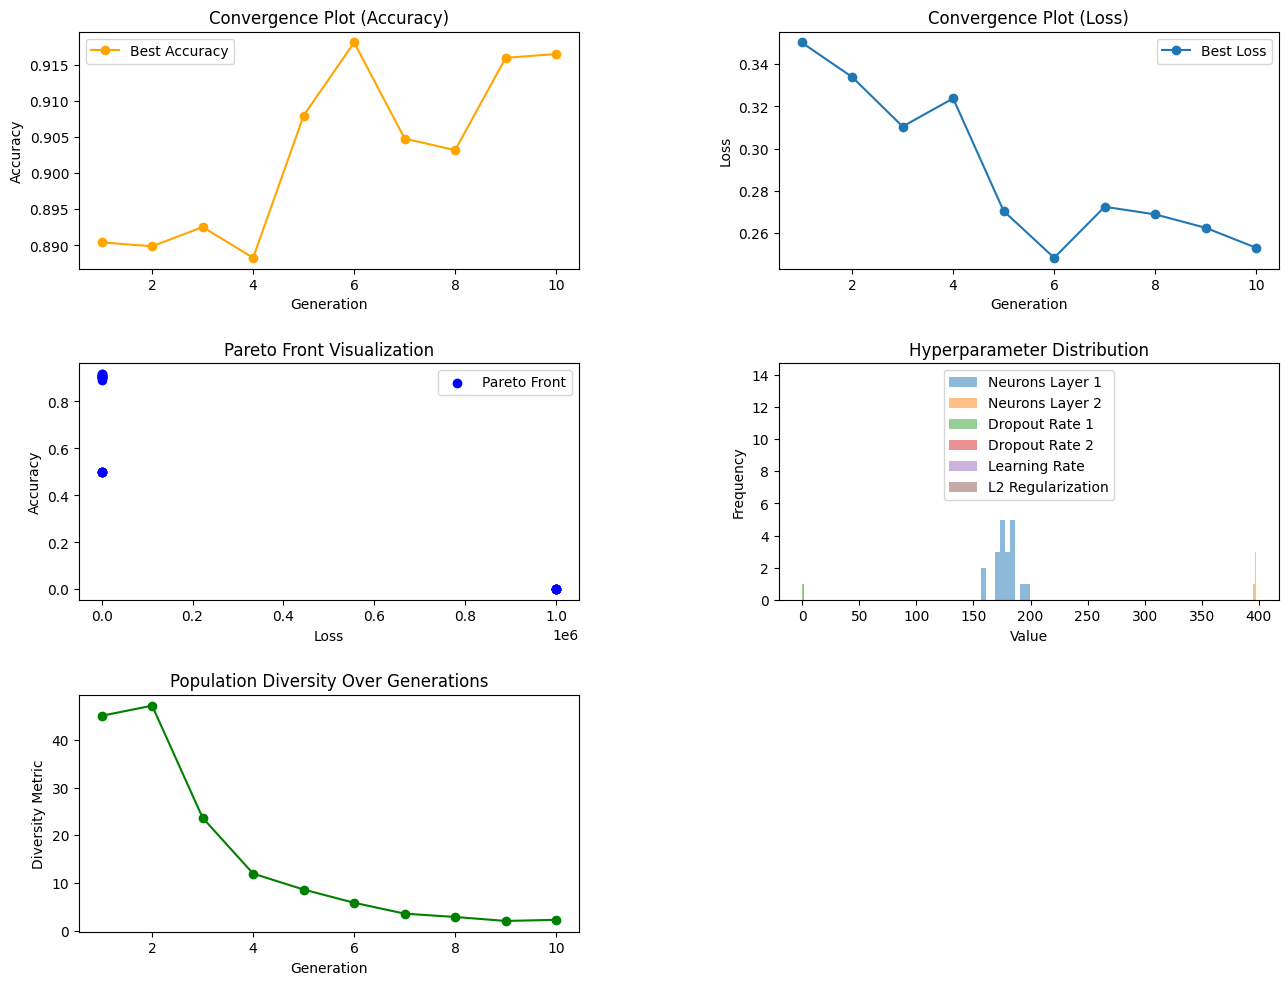

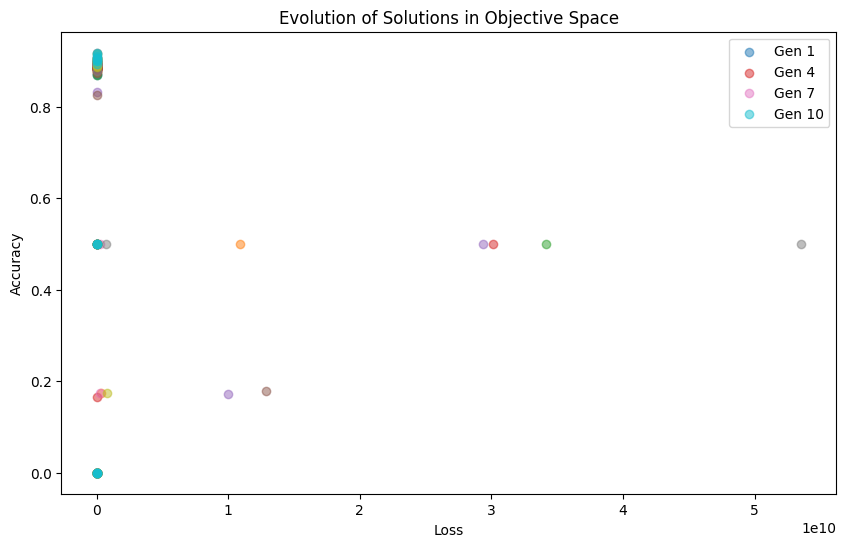

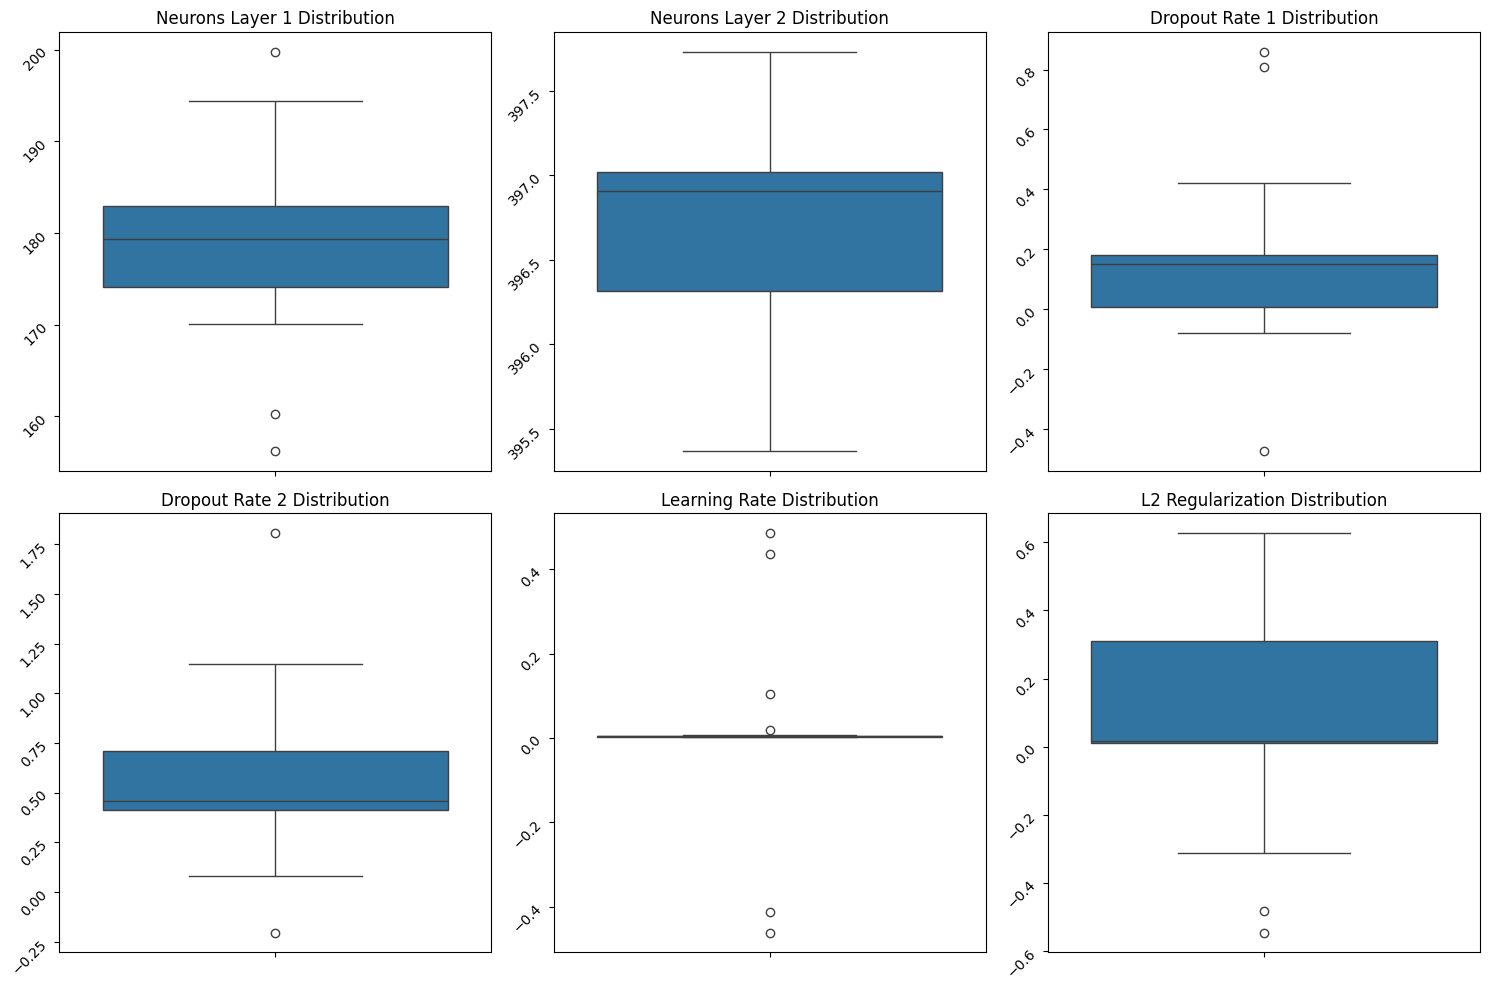


Best Overall Individual Hyperparameters: [189.0645622659005, 396.73861085455394, 0.14970614342120847, 0.3995547694370051, 0.0025526621349406904, 0.007007354490342587]

Training Final Model with Optimized Hyperparameters:
Layer 1 Neurons: 189
Layer 2 Neurons: 396
Dropout Rate 1: 0.14970614342120847
Dropout Rate 2: 0.3995547694370051
Learning Rate: 0.0025526621349406904
L2 Regularization: 0.007007354490342587
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8512 - loss: 1.2832 - val_accuracy: 0.8843 - val_loss: 0.3651
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8924 - loss: 0.3456 - val_accuracy: 0.8896 - val_loss: 0.3167
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8977 - loss: 0.3082 - val_accuracy: 0.8816 - val_loss: 0.3014
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8947 - loss: 0.2958 - val_accuracy: 0.8890 - val_loss: 0.2952
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8928 - loss: 0.2912 - v

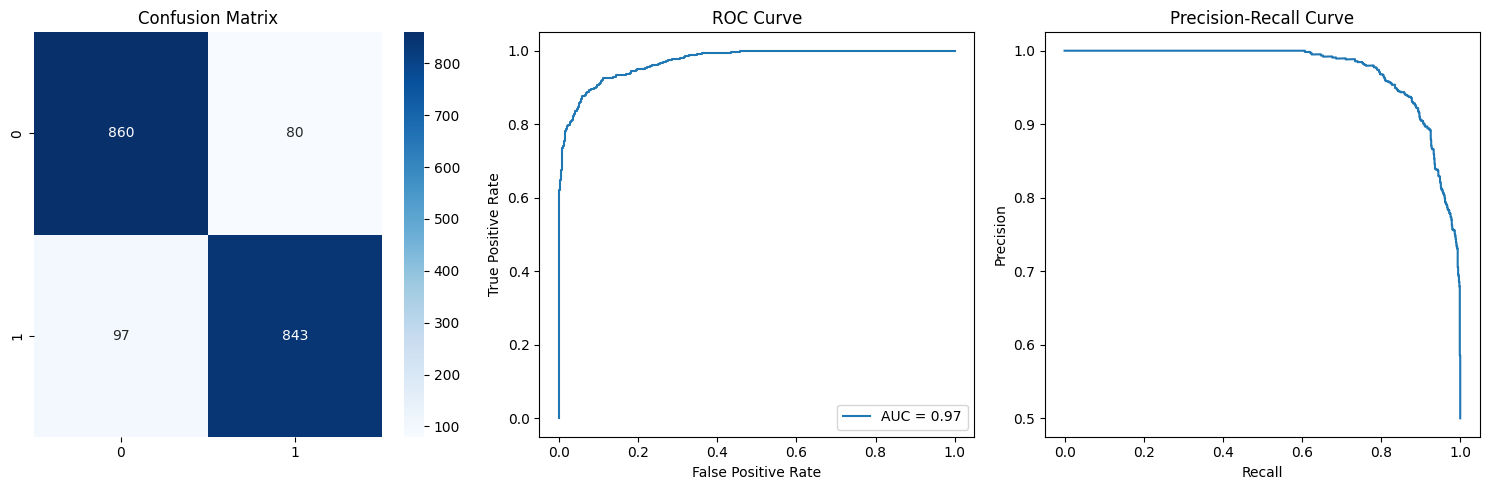

In [11]:
# Run the optimizer
if __name__ == "__main__":
    filepath = r"/content/cleaned-stroke-prediction-dataset-balanced.csv"
    optimizer = StrokeModelOptimizer(filepath)
    optimizer.run_optimization()